In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25744\2419121426.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")


In [3]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  -0.332139   1.460207  -0.082405   0.945965 -0.556532   8.282122   
1  0.003906   0.455678  -0.506964  -8.182390   2.241613  3.137224  18.753385   
2  0.007812  -0.995135  -3.805043 -15.517629   2.785924  5.121238  26.958536   
3  0.011719  -5.017469  -7.255061 -18.758616   1.417463  5.081020  29.945681   
4  0.015625 -10.258652  -9.017413 -16.288979  -2.295541  4.092776  27.027844   

   EOG E2-M2        ECG      Annotation  
0  -6.846270 -36.322502   Sleep stage W  
1  -6.397049 -36.334116   Sleep stage W  
2  -7.204251 -37.603388   Sleep stage W  
3  -9.951360 -42.065282   Sleep stage W  
4 -13.573874 -50.681696   Sleep stage W  


In [4]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [5]:
# 1. ตรวจหา NaN
print("NaN in data:", np.isnan(data).any())
print("NaN in labels:", pd.isna(labels).any())

NaN in data: EEG F4-M1    False
EEG C4-M1    False
EEG O2-M1    False
EEG C3-M2    False
EMG chin     False
EOG E1-M2    False
EOG E2-M2    False
ECG          False
dtype: bool
NaN in labels: True


In [6]:
# ลบแถวที่ labels เป็น NaN
mask = labels.notna()           
data = data[mask]
labels = labels[mask]

# รีเซ็ต index ใหม่ให้ตรงกัน
data = data.reset_index(drop=True)
labels = labels.reset_index(drop=True)


In [7]:
X_train_df, X_temp_df, y_train_df, y_temp_df = train_test_split(
    data,
    labels,
    test_size=0.3,               # 70% train, 30% temp
    stratify=labels,            # ให้สัดส่วนคลาสเหมือนเดิม
    random_state=42             # เพื่อให้ reproducible
)

# ---- 2️⃣ แบ่ง Temp เป็น Validation / Test ----
X_val_df, X_test_df, y_val_df, y_test_df = train_test_split(
    X_temp_df,
    y_temp_df,
    test_size=0.5,              # 50% ของ temp = 15% ของทั้งหมด
    stratify=y_temp_df,        # stratify อีกครั้ง
    random_state=42
)

# ---- ตรวจสอบ shape ----
print("Train:", X_train_df.shape, y_train_df.shape)
print("Val:  ", X_val_df.shape, y_val_df.shape)
print("Test: ", X_test_df.shape, y_test_df.shape)

# ---- ตรวจสอบ distribution แต่ละเซต ----
print("\nTrain distribution:\n", y_train_df.value_counts(normalize=True))
print("\nVal distribution:\n", y_val_df.value_counts(normalize=True))
print("\nTest distribution:\n", y_test_df.value_counts(normalize=True))

Train: (4591104, 8) (4591104,)
Val:   (983808, 8) (983808,)
Test:  (983808, 8) (983808,)

Train distribution:
 Annotation
Sleep stage N2    0.503513
Sleep stage W     0.176815
Sleep stage R     0.165105
Sleep stage N1    0.127635
Sleep stage N3    0.026932
Name: proportion, dtype: float64

Val distribution:
 Annotation
Sleep stage N2    0.503513
Sleep stage W     0.176815
Sleep stage R     0.165105
Sleep stage N1    0.127635
Sleep stage N3    0.026932
Name: proportion, dtype: float64

Test distribution:
 Annotation
Sleep stage N2    0.503513
Sleep stage W     0.176815
Sleep stage R     0.165105
Sleep stage N1    0.127635
Sleep stage N3    0.026932
Name: proportion, dtype: float64


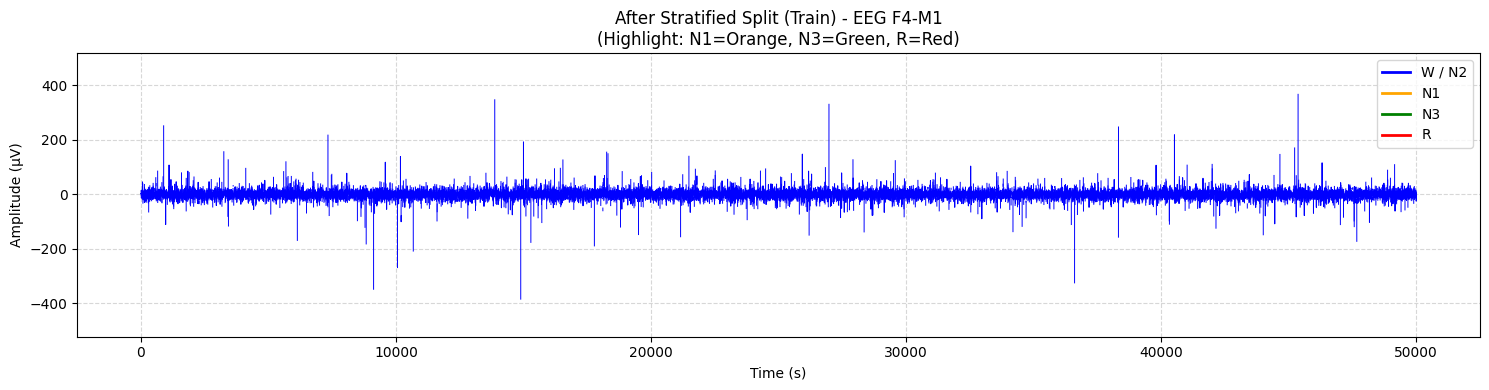

In [37]:

def plot_train_highlight_classes(X_train_df, y_train_df, channel='EEG F4-M1', n_samples=200000):
    """
    พล็อตสัญญาณ EEG หลัง stratified split 
    และเน้นสีพิเศษสำหรับ N3 (เขียว), R (แดง), N1 (ส้ม)
    """
    # ถ้า y_train_df เป็น numpy array → แปลงเป็น Series ก่อน
    if not isinstance(y_train_df, pd.Series):
        y_train_df = pd.Series(y_train_df)

    # จำกัดจำนวน sample
    n_samples = min(n_samples, len(X_train_df))
    signal = X_train_df[channel].iloc[:n_samples].values
    labels = y_train_df.iloc[:n_samples].values

    # Time axis
    if 'Time' in X_train_df.columns:
        time = X_train_df['Time'].iloc[:n_samples].values
    else:
        time = np.arange(n_samples)

    # 🎨 Mapping class → color
    color_map = {
        'N3': 'green',    # N3 → เขียว
        'R': 'red',       # R → แดง
        'N1': 'orange'    # N1 → ส้ม
    }
    default_color = 'blue'  # W, N2 = ฟ้า

    plt.figure(figsize=(15, 4))
    start_idx = 0

    # วน loop segment
    for i in range(1, n_samples):
        if labels[i] != labels[start_idx]:
            segment_label = labels[start_idx]
            color = color_map.get(segment_label, default_color)
            plt.plot(time[start_idx:i], signal[start_idx:i], color=color, linewidth=0.7)
            start_idx = i

    # Segment สุดท้าย
    segment_label = labels[start_idx]
    color = color_map.get(segment_label, default_color)
    plt.plot(time[start_idx:], signal[start_idx:], color=color, linewidth=0.7)

    # 📝 Legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', lw=2, label='W / N2'),
        plt.Line2D([0], [0], color='orange', lw=2, label='N1'),
        plt.Line2D([0], [0], color='green', lw=2, label='N3'),
        plt.Line2D([0], [0], color='red', lw=2, label='R')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(f'After Stratified Split (Train) - {channel}\n(Highlight: N1=Orange, N3=Green, R=Red)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
plot_train_highlight_classes(X_train_df, y_train_df, channel='EEG F4-M1', n_samples=50000)


In [8]:
y_train_df.value_counts(), y_val_df.value_counts(), y_test_df.value_counts()

(Annotation
 Sleep stage N2    2311680
 Sleep stage W      811776
 Sleep stage R      758016
 Sleep stage N1     585984
 Sleep stage N3     123648
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    495360
 Sleep stage W     173952
 Sleep stage R     162432
 Sleep stage N1    125568
 Sleep stage N3     26496
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    495360
 Sleep stage W     173952
 Sleep stage R     162432
 Sleep stage N1    125568
 Sleep stage N3     26496
 Name: count, dtype: int64)

## Sliding window

In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานชัวร์
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        if len(label_slice) == 0 or label_slice.mode().empty:
            continue  # ข้าม window ที่ไม่มีข้อมูล

        label_value = label_slice.mode().iloc[0]

        window_data.append(window)
        window_label.append(label_value)

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y

In [15]:
selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2']

X_train_df_reduced = X_train_df[selected_channels]
X_val_df_reduced   = X_val_df[selected_channels]
X_test_df_reduced  = X_test_df[selected_channels]

In [16]:
# -----------------------------
# 1. ทำ sliding window ก่อน
# -----------------------------
window_size = 256
step_size = 128

X_train, y_train = apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val     = apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test   = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced = apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced     = apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced   = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

print("Before SMOTE: X_train:", X_train.shape, ", y_train:", y_train.shape)

print("X_train:" ,X_train.shape, ", y_train:", y_train.shape)
print("X_val:" ,X_val.shape, ", y_val:", y_val.shape)
print("X_test:" ,X_test.shape, ", y_test:", y_test.shape)

print("X_train_reduced:" ,X_train_reduced.shape, ", y_train_reduced:", y_train_reduced.shape)
print("X_val_reduced:" ,X_val_reduced.shape, ", y_val_reduced:", y_val_reduced.shape)
print("X_test_reduced:" ,X_test_reduced.shape, ", y_test_reduced:", y_test_reduced.shape)

Before SMOTE: X_train: (35867, 256, 8) , y_train: (35867,)
X_train: (35867, 256, 8) , y_train: (35867,)
X_val: (7685, 256, 8) , y_val: (7685,)
X_test: (7685, 256, 8) , y_test: (7685,)
X_train_reduced: (35867, 256, 4) , y_train_reduced: (35867,)
X_val_reduced: (7685, 256, 4) , y_val_reduced: (7685,)
X_test_reduced: (7685, 256, 4) , y_test_reduced: (7685,)


In [17]:
print("Train dist:\n", pd.Series(y_train).value_counts())
print("Val dist:\n", pd.Series(y_val).value_counts())
print("Test dist:\n", pd.Series(y_test).value_counts())
print("Before window:", df['Annotation'].value_counts())

y_train_series = pd.Series(y_train)
print("After window (train):", y_train_series.value_counts())

Train dist:
 Sleep stage N2    35867
Name: count, dtype: int64
Val dist:
 Sleep stage N2    7685
Name: count, dtype: int64
Test dist:
 Sleep stage N2    7685
Name: count, dtype: int64
Before window: Annotation
Sleep stage N2    3302400
Sleep stage W     1159680
Sleep stage R     1082880
Sleep stage N1     837120
Sleep stage N3     176640
Name: count, dtype: int64
After window (train): Sleep stage N2    35867
Name: count, dtype: int64


In [19]:


print("y_train dist:\n", pd.Series(y_train).value_counts())
print("y_val dist:\n", pd.Series(y_val).value_counts())
print("y_test dist:\n", pd.Series(y_test).value_counts())


y_train dist:
 Sleep stage N2    35867
Name: count, dtype: int64
y_val dist:
 Sleep stage N2    7685
Name: count, dtype: int64
y_test dist:
 Sleep stage N2    7685
Name: count, dtype: int64


In [ ]:
from collections import Counter

print("Class distribution before SMOTE:", Counter(y_train))

In [15]:
# 2. Flatten สำหรับ SMOTE
# -----------------------------
nsamples, timesteps, nchannels = X_train.shape
X_train_flat = X_train.reshape((nsamples, timesteps * nchannels))

In [24]:
# -----------------------------
# 3. Oversample ด้วย SMOTE
# -----------------------------
smt = SMOTE(sampling_strategy="auto", random_state=42)
X_train_flat_res, y_train_res = smt.fit_resample(X_train_flat, y_train)

print("After SMOTE: X_train_flat_res:", X_train_flat_res.shape, ", y_train_res:", y_train_res.shape)


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [18]:
# -----------------------------
# 4. Reshape กลับสำหรับ LSTM
# -----------------------------
X_train_res = X_train_flat_res.reshape((-1, timesteps, nchannels))

print("Final X_train_res shape:", X_train_res.shape, ", y_train_res:", y_train_res.shape)

Final X_train_res shape: (88300, 256, 8) , y_train_res: (88300,)


In [19]:
X_train_df.shape, X_val_df.shape, X_test_df.shape

((4596480, 8), (656639, 8), (1313279, 8))

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


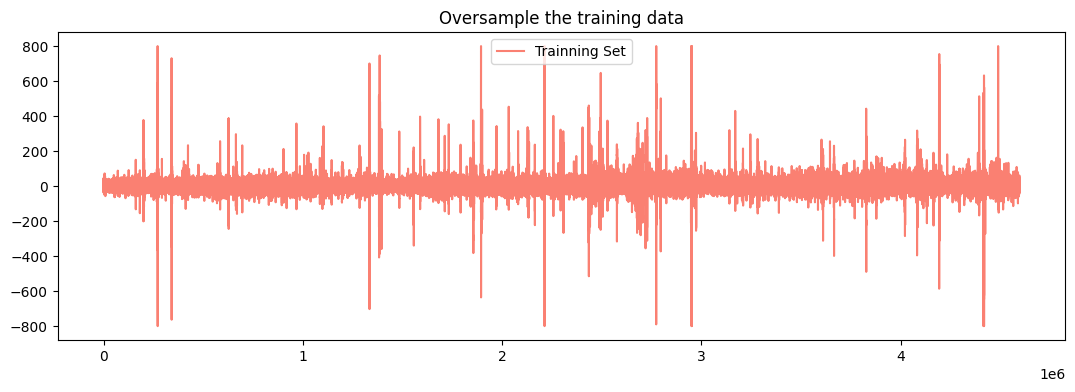

In [20]:
plt.figure(figsize=(13,4))
plt.plot(X_train_df['EEG F4-M1'], color='salmon', label='Trainning Set')
plt.legend()
plt.title('Oversample the training data')
plt.show()

In [21]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596480 entries, 0 to 4596479
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   EEG F4-M1  float64
 1   EEG C4-M1  float64
 2   EEG O2-M1  float64
 3   EEG C3-M2  float64
 4   EMG chin   float64
 5   EOG E1-M2  float64
 6   EOG E2-M2  float64
 7   ECG        float64
dtypes: float64(8)
memory usage: 280.5 MB


Sample (original y_train_df):
Annotation
Sleep stage N2    2261760
Sleep stage W      906240
Sleep stage N1     660480
Sleep stage R      629760
Sleep stage N3     138240
Name: count, dtype: int64
After Sliding Window (selected channels y_train_reduced):
Sleep stage N2    17660
Sleep stage W      7071
Sleep stage N1     5188
Sleep stage R      4916
Sleep stage N3     1074
Name: count, dtype: int64
                N Sample
Annotation              
Sleep stage N2   2261760
Sleep stage W     906240
Sleep stage N1    660480
Sleep stage R     629760
Sleep stage N3    138240


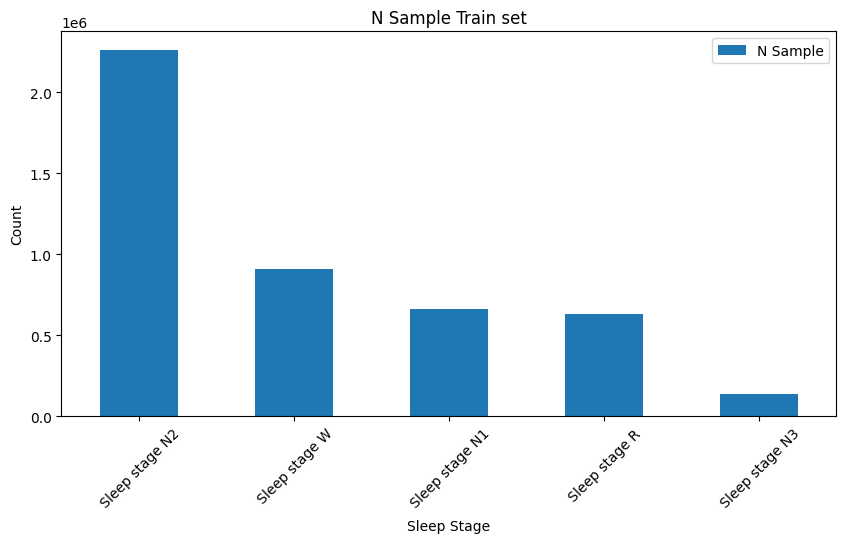

In [30]:
print("Sample (original y_train_df):")
print(y_train_df.value_counts())
print("After Sliding Window (selected channels y_train_reduced):")
print(pd.Series(y_train_reduced).value_counts())
# รวมผลเป็น DataFrame เพื่อเทียบง่าย ๆ
annotation_check = pd.DataFrame({
    "N Sample": y_train_df.value_counts(),
}).fillna(0).astype(int)

print(annotation_check)
annotation_check.plot(kind="bar", figsize=(10, 5))
plt.title("N Sample Train set")
plt.ylabel("Count")
plt.xlabel("Sleep Stage")
plt.xticks(rotation=45)
plt.show()


In [18]:
print("Before (%):")
print(y_train_df.value_counts(normalize=True) * 100)

print("\nAfter Sliding Window (%):")
print(pd.Series(y_train).value_counts(normalize=True) * 100)


Before (%):
Annotation
Sleep stage N2    49.206349
Sleep stage W     19.715957
Sleep stage N1    14.369256
Sleep stage R     13.700919
Sleep stage N3     3.007519
Name: proportion, dtype: float64

After Sliding Window (%):
Sleep stage N2    49.214569
Sleep stage W     19.711936
Sleep stage N1    14.381446
Sleep stage R     13.702624
Sleep stage N3     2.989426
Name: proportion, dtype: float64


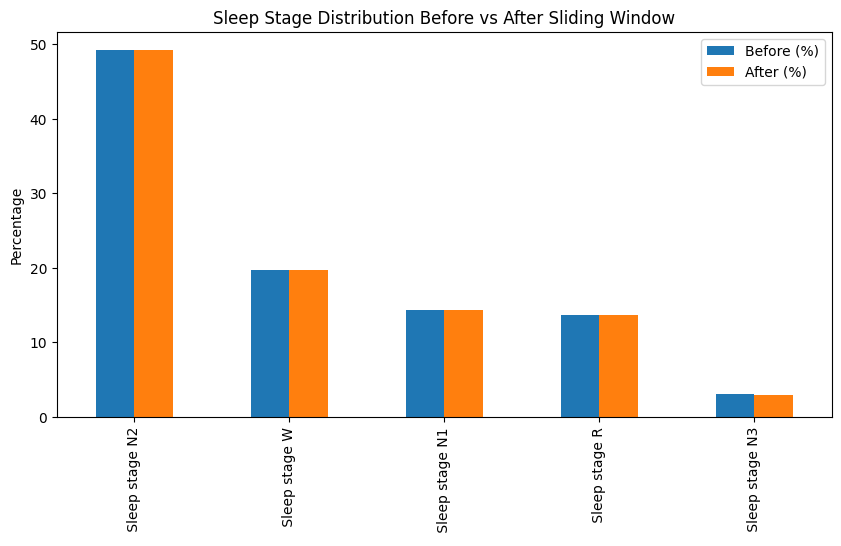

In [19]:


before = y_train_df.value_counts(normalize=True) * 100
after = pd.Series(y_train).value_counts(normalize=True) * 100

compare_df = pd.DataFrame({'Before (%)': before, 'After (%)': after}).fillna(0)

compare_df.plot(kind='bar', figsize=(10,5))
plt.title("Sleep Stage Distribution Before vs After Sliding Window")
plt.ylabel("Percentage")
plt.show()


In [20]:
print("Before SMOTE:", y_train_df.value_counts())
print("After SMOTE:", pd.Series(y_train).value_counts())  # หลังจาก sliding window

Before SMOTE: Annotation
Sleep stage N2    2261760
Sleep stage W      906240
Sleep stage N1     660480
Sleep stage R      629760
Sleep stage N3     138240
Name: count, dtype: int64
After SMOTE: Sleep stage N2    11310
Sleep stage W      4530
Sleep stage N1     3305
Sleep stage R      3149
Sleep stage N3      687
Name: count, dtype: int64


## Train

In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [32]:
# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))  # เอาจาก train set เท่านั้น

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

# ensure shape = (samples, timesteps, features)
if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------
model1 = Sequential()
model1.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

# -----------------------------
# 4. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
)


X_train shape: (35909, 256, 8)
y_train shape: (35909, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,055 (47.09 KB)

 Trainable params: 12,055 (47.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.5810 - loss: 1.2293 - val_accuracy: 0.1800 - val_loss: 1.5375
Epoch 2/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.5666 - loss: 1.2322 - val_accuracy: 0.3296 - val_loss: 1.4272
Epoch 3/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.5674 - loss: 1.2200 - val_accuracy: 0.2582 - val_loss: 1.4142
Epoch 4/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.5623 - loss: 1.2255 - val_accuracy: 0.3138 - val_loss: 1.3548
Epoch 5/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.5477 - loss: 1.2382 - val_accuracy: 0.2939 - val_loss: 1.3617
Epoch 6/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.5558 - loss: 1.2190 - val_accuracy: 0.3155 - val_loss: 1.3453
Epoch 7/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.5690 - loss: 1.1998 - val_accuracy: 0.2603 - val_loss: 1.3808
Epoch 8/100
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 

In [33]:

# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3608 - loss: 1.7213
Test Loss: 1.7213, Test Accuracy: 36.08%


In [ ]:
model1.save("LSTM20unit.h55")

In [34]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [39]:
print(np.sum(y_test_cat, axis=0))  # นับจำนวนตัวอย่างแต่ละคลาส

[1320. 3539.    0. 3540. 1801.]


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


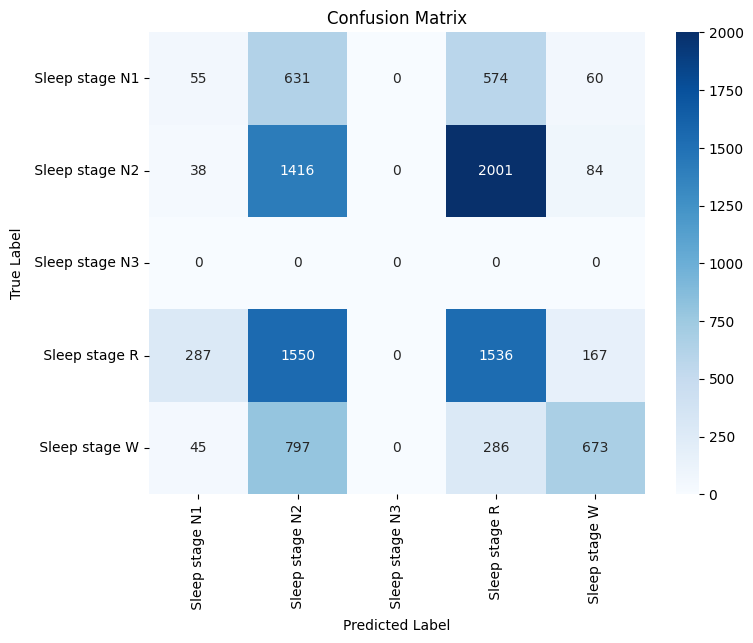

                 precision    recall  f1-score   support

 Sleep stage N1       0.13      0.04      0.06      1320
 Sleep stage N2       0.32      0.40      0.36      3539
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.35      0.43      0.39      3540
  Sleep stage W       0.68      0.37      0.48      1801

       accuracy                           0.36     10200
      macro avg       0.30      0.25      0.26     10200
   weighted avg       0.37      0.36      0.35     10200



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [42]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model1.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
all_labels = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_true, y_pred, labels=all_labels)
# --------------------------
# 3. Plot confusion matrix
# --------------------------

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred,
                            labels=all_labels,
                            target_names=encoder.classes_))

## ลองทำ Class Weight

In [58]:
from sklearn.utils.class_weight import compute_class_weight


In [59]:

# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:  # reshape ให้เป็น (samples, timesteps, features)
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------
model1 = Sequential()
model1.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

X_train shape: (22981, 400, 8)
y_train shape: (22981, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,055 (47.09 KB)

 Trainable params: 12,055 (47.09 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# -----------------------------
# 4. คำนวณ class weights
# -----------------------------
classes = np.unique(y_train_enc)
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=classes,
                                     y=y_train_enc)
class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)

# -----------------------------
# 5. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
    class_weight=class_weights   #  เพิ่มตรงนี้
)

Class weights: {np.int64(0): np.float64(1.390680786686838), np.int64(1): np.float64(0.40638373121131743), np.int64(2): np.float64(6.6902474526928675), np.int64(3): np.float64(1.4595744680851064), np.int64(4): np.float64(1.0146136865342164)}
Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.3244 - loss: 1.7485 - val_accuracy: 0.0122 - val_loss: 2.0335
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 118s 107ms/step - accuracy: 0.2546 - loss: 1.6393 - val_accuracy: 0.0420 - val_loss: 1.8451
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 79s 109ms/step - accuracy: 0.2468 - loss: 1.6082 - val_accuracy: 0.0600 - val_loss: 1.7354
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 53s 73ms/step - accuracy: 0.2489 - loss: 1.5766 - val_accuracy: 0.0463 - val_loss: 1.7747
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.2488 - loss: 1.5567 - val_accuracy: 0.0445 - val_loss: 1.8223
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 70s 98ms/step - accuracy: 0.2516 - loss: 1.5353 - val_accura

In [62]:

# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3467 - loss: 1.7738
Test Loss: 1.7738, Test Accuracy: 34.67%


In [63]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


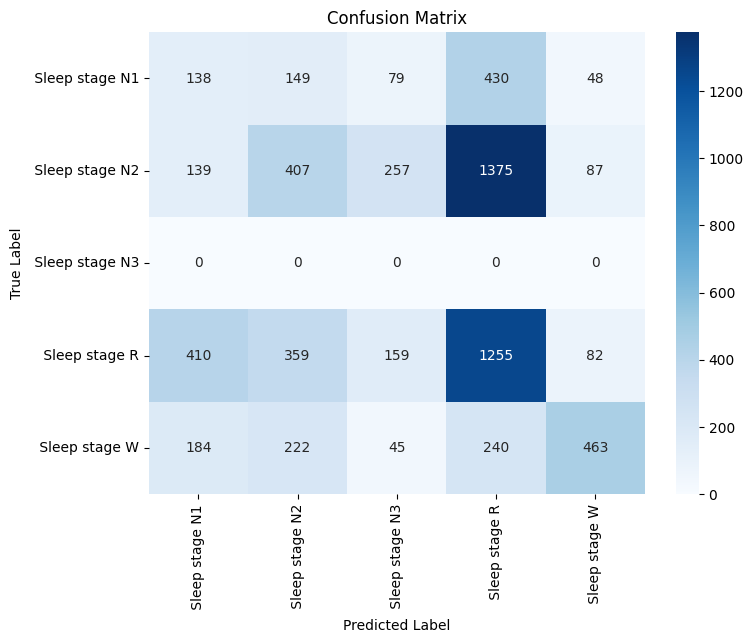

                 precision    recall  f1-score   support

 Sleep stage N1       0.16      0.16      0.16       844
 Sleep stage N2       0.36      0.18      0.24      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.38      0.55      0.45      2265
  Sleep stage W       0.68      0.40      0.50      1154

       accuracy                           0.35      6528
      macro avg       0.32      0.26      0.27      6528
   weighted avg       0.40      0.35      0.35      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [64]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model1.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

## ลองใช้ focal loss

In [65]:
def categorical_focal_loss(gamma=2., alpha=0.25):
    """
    Focal loss for multi-class classification
    gamma: focusing parameter (default = 2.0)
    alpha: balancing factor (default = 0.25)
    """
    def loss(y_true, y_pred):
        # ป้องกัน log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)  # sum over classes
    return loss

In [66]:
from tensorflow.keras import backend as K

# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:  # reshape ให้เป็น (samples, timesteps, features)
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)
# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------
model1 = Sequential()
model1.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(num_classes, activation='softmax'))

# ใช้ focal loss แทน crossentropy
model1.compile(optimizer='adam',
               loss=categorical_focal_loss(gamma=2., alpha=0.25),
               metrics=['accuracy'])

model1.summary()

# -----------------------------
# 4. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
)

X_train shape: (22981, 400, 8)
y_train shape: (22981, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,055 (47.09 KB)

 Trainable params: 12,055 (47.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.5402 - loss: 0.1987 - val_accuracy: 0.1475 - val_loss: 0.2221
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 53s 74ms/step - accuracy: 0.5411 - loss: 0.1843 - val_accuracy: 0.2145 - val_loss: 0.2053
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 55s 76ms/step - accuracy: 0.5334 - loss: 0.1836 - val_accuracy: 0.2824 - val_loss: 0.1967
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 60s 83ms/step - accuracy: 0.5280 - loss: 0.1829 - val_accuracy: 0.3087 - val_loss: 0.1965
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.5260 - loss: 0.1830 - val_accuracy: 0.3477 - val_loss: 0.1907
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.5243 - loss: 0.1826 - val_accuracy: 0.3400 - val_loss: 0.1926
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.5247 - loss: 0.1824 - val_accuracy: 0.4759 - val_loss: 0.1781
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.5290 - loss: 0

In [67]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3681 - loss: 0.2711
Test Loss: 0.2711, Test Accuracy: 36.81%


In [68]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


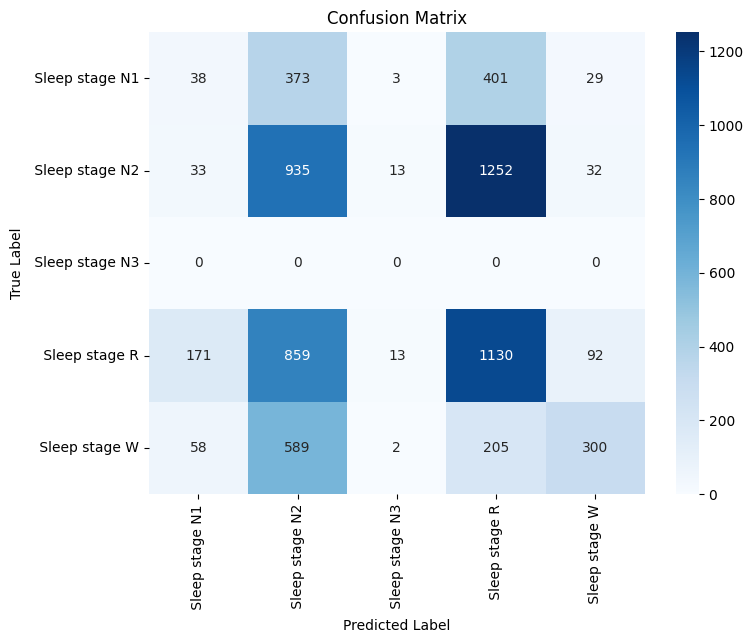

                 precision    recall  f1-score   support

 Sleep stage N1       0.13      0.05      0.07       844
 Sleep stage N2       0.34      0.41      0.37      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.38      0.50      0.43      2265
  Sleep stage W       0.66      0.26      0.37      1154

       accuracy                           0.37      6528
      macro avg       0.30      0.24      0.25      6528
   weighted avg       0.38      0.37      0.35      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [69]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model1.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

## ลองใช้ Class Weight และ CNN + LSTM

In [44]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

In [33]:

# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:  # reshape ให้เป็น (samples, timesteps, features)
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------

model1 = Sequential()

# 1D CNN layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

# LSTM layer
model1.add(LSTM(64, return_sequences=False))  # return_sequences=False เพราะต่อ Dense

# Output layer
model1.add(Dense(num_classes, activation='softmax'))

# Compile
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

X_train shape: (22981, 400, 8)
y_train shape: (22981, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 398, 64)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 199, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 199, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,949 (136.52 KB)

 Trainable params: 34,949 (136.52 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# -----------------------------
# 4. คำนวณ class weights
# -----------------------------
classes = np.unique(y_train_enc)
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=classes,
                                     y=y_train_enc)
class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)

# -----------------------------
# 5. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
    class_weight=class_weights   #  เพิ่มตรงนี้
)

Class weights: {np.int64(0): np.float64(1.390680786686838), np.int64(1): np.float64(0.40638373121131743), np.int64(2): np.float64(6.6902474526928675), np.int64(3): np.float64(1.4595744680851064), np.int64(4): np.float64(1.0146136865342164)}
Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.3241 - loss: 1.8318 - val_accuracy: 0.0000e+00 - val_loss: 2.7761
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.2818 - loss: 1.7674 - val_accuracy: 0.0000e+00 - val_loss: 2.3869
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.2017 - loss: 1.7369 - val_accuracy: 0.0000e+00 - val_loss: 2.1208
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.2069 - loss: 1.7310 - val_accuracy: 0.0000e+00 - val_loss: 2.4250
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.2311 - loss: 1.7058 - val_accuracy: 0.0000e+00 - val_loss: 2.4048
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.2556 - loss: 1.

In [35]:

# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.2382 - loss: 2.3370
Test Loss: 2.3370, Test Accuracy: 23.82%


In [36]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


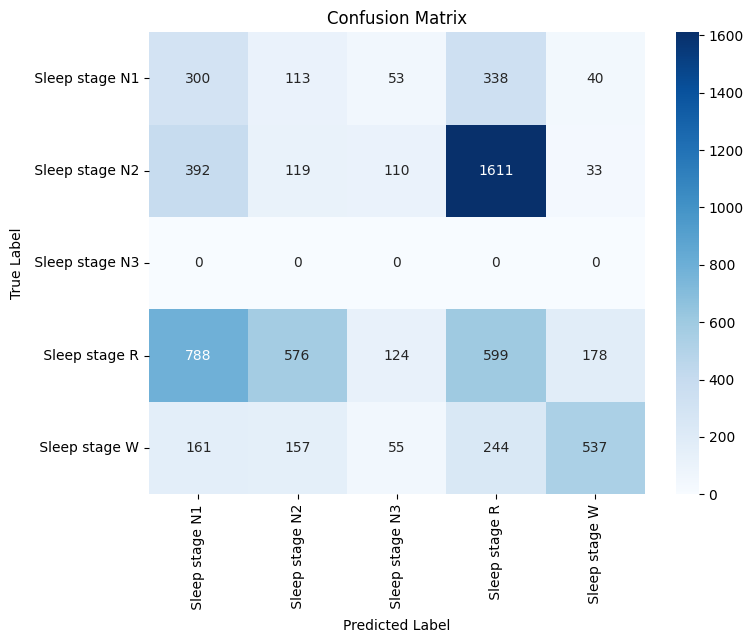

                 precision    recall  f1-score   support

 Sleep stage N1       0.18      0.36      0.24       844
 Sleep stage N2       0.12      0.05      0.07      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.21      0.26      0.24      2265
  Sleep stage W       0.68      0.47      0.55      1154

       accuracy                           0.24      6528
      macro avg       0.24      0.23      0.22      6528
   weighted avg       0.26      0.24      0.24      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [37]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model1.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

### ลองใช้แต่CNN

In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [30]:

# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32 และ shape = (samples, timesteps, features)
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)  # (samples, timesteps, channels)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()




X_train shape: (22981, 400, 8)
y_train shape: (22981, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 394, 32)        │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 394, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 197, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 193, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 193, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 94, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 94, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 47, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 43, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 43, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1344)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       172,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,813 (983.64 KB)

 Trainable params: 251,237 (981.39 KB)

 Non-trainable params: 576 (2.25 KB)

In [31]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
)

Epoch 1/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5947 - loss: 1.1051 - val_accuracy: 0.8723 - val_loss: 0.4926
Epoch 2/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7304 - loss: 0.7300 - val_accuracy: 0.7940 - val_loss: 0.7660
Epoch 3/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7615 - loss: 0.6572 - val_accuracy: 0.8083 - val_loss: 0.8041
Epoch 4/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7781 - loss: 0.6031 - val_accuracy: 0.8294 - val_loss: 0.7835
Epoch 5/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7888 - loss: 0.5669 - val_accuracy: 0.7849 - val_loss: 0.8793
Epoch 6/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7990 - loss: 0.5402 - val_accuracy: 0.8446 - val_loss: 0.7893
Epoch 7/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8109 - loss: 0.5058 - val_accuracy: 0.7060 - val_loss: 0.9985
Epoch 8/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8200 - loss: 0.4826 - val_

In [32]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4187 - loss: 9.4036 
Test Loss: 9.4036, Test Accuracy: 41.87%


In [33]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


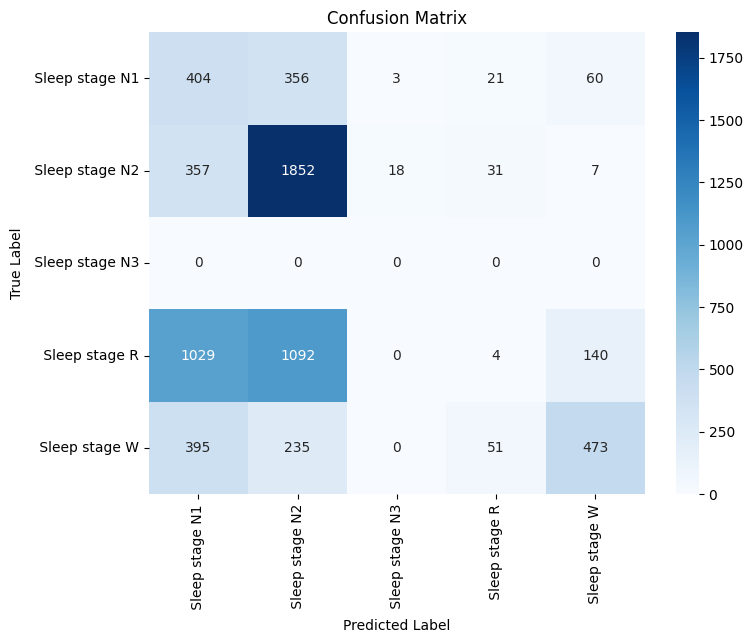

                 precision    recall  f1-score   support

 Sleep stage N1       0.18      0.48      0.27       844
 Sleep stage N2       0.52      0.82      0.64      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.04      0.00      0.00      2265
  Sleep stage W       0.70      0.41      0.52      1154

       accuracy                           0.42      6528
      macro avg       0.29      0.34      0.28      6528
   weighted avg       0.34      0.42      0.35      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [35]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

## ลองทำ CNN+Class weight

In [37]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [38]:
# -----------------------------
# 1. Encode labels
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. Compute class weights
# -----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# -----------------------------
# 3. CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


Class Weights: {0: np.float64(1.390680786686838), 1: np.float64(0.40638373121131743), 2: np.float64(6.6902474526928675), 3: np.float64(1.4595744680851064), 4: np.float64(1.0146136865342164)}


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
)

Epoch 1/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5710 - loss: 1.1410 - val_accuracy: 0.9040 - val_loss: 0.4769
Epoch 2/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7195 - loss: 0.7445 - val_accuracy: 0.9004 - val_loss: 0.5849
Epoch 3/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7614 - loss: 0.6513 - val_accuracy: 0.8650 - val_loss: 0.7277
Epoch 4/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7822 - loss: 0.5945 - val_accuracy: 0.8522 - val_loss: 0.7769
Epoch 5/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7969 - loss: 0.5546 - val_accuracy: 0.7791 - val_loss: 0.9118
Epoch 6/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8068 - loss: 0.5218 - val_accuracy: 0.8355 - val_loss: 0.9164
Epoch 7/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8156 - loss: 0.4938 - val_accuracy: 0.8522 - val_loss: 0.7846
Epoch 8/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8261 - loss: 0.4681 - val_acc

In [40]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3675 - loss: 15.9553
Test Loss: 15.9553, Test Accuracy: 36.75%


In [41]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


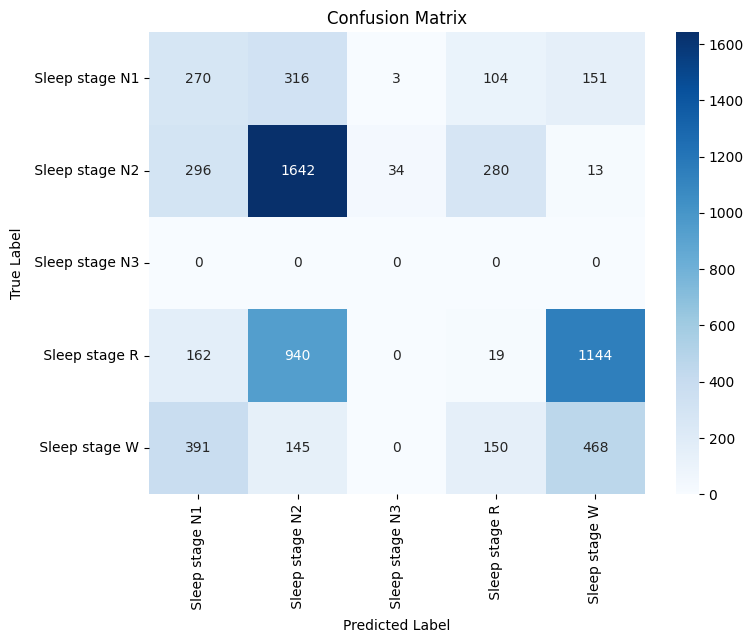

                 precision    recall  f1-score   support

 Sleep stage N1       0.24      0.32      0.28       844
 Sleep stage N2       0.54      0.72      0.62      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.03      0.01      0.01      2265
  Sleep stage W       0.26      0.41      0.32      1154

       accuracy                           0.37      6528
      macro avg       0.22      0.29      0.25      6528
   weighted avg       0.28      0.37      0.31      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [42]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

## CNN+LSTM แบบสุดโหด

In [48]:
# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:  # reshape ให้เป็น (samples, timesteps, features)
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------

model1 = Sequential()

# 1D CNN layer

model1.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

model1.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

model1.add(Conv1D(filters=128, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

model1.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))


# LSTM layer
model1.add(LSTM(64, return_sequences=False))  # return_sequences=False เพราะต่อ Dense

# Output layer
model1.add(Dense(num_classes, activation='softmax'))

# Compile
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

X_train shape: (22981, 400, 8)
y_train shape: (22981, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 398, 32)        │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 197, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 96, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 46, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,701 (350.39 KB)

 Trainable params: 89,701 (350.39 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# -----------------------------
# 4. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
)

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5801 - loss: 1.3363 - val_accuracy: 0.0000e+00 - val_loss: 2.5991
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5692 - loss: 1.3090 - val_accuracy: 0.0000e+00 - val_loss: 1.8283
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5519 - loss: 1.3402 - val_accuracy: 0.0000e+00 - val_loss: 1.6968
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5403 - loss: 1.2900 - val_accuracy: 0.0116 - val_loss: 1.8017
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6117 - loss: 1.2237 - val_accuracy: 0.8952 - val_loss: 1.3344
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5913 - loss: 1.2529 - val_accuracy: 0.0000e+00 - val_loss: 1.8345
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5809 - loss: 1.2530 - val_accuracy: 0.0000e+00 - val_loss: 1.3816
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5

In [54]:

# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3470 - loss: 1.4077
Test Loss: 1.4077, Test Accuracy: 34.70%


In [55]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


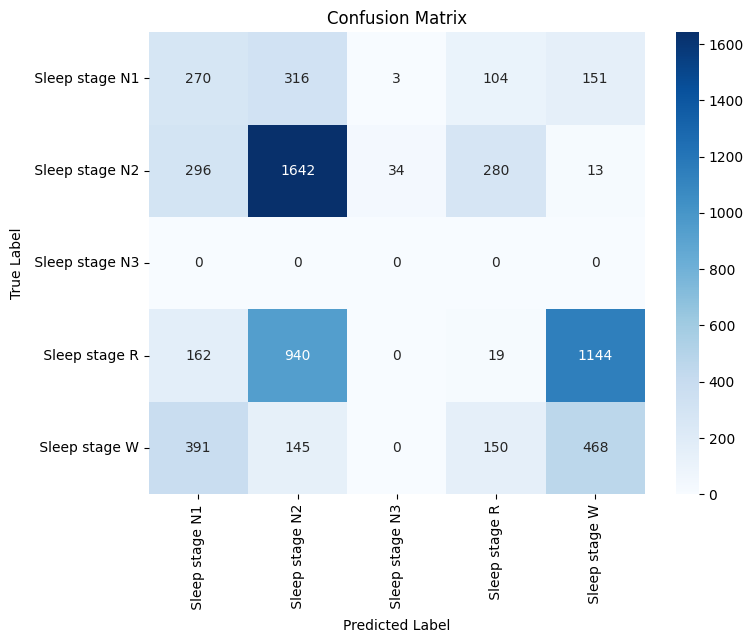

                 precision    recall  f1-score   support

 Sleep stage N1       0.24      0.32      0.28       844
 Sleep stage N2       0.54      0.72      0.62      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.03      0.01      0.01      2265
  Sleep stage W       0.26      0.41      0.32      1154

       accuracy                           0.37      6528
      macro avg       0.22      0.29      0.25      6528
   weighted avg       0.28      0.37      0.31      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [57]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

## STACK LSTM + CNN แบบสุดโหด

In [59]:
# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:  # reshape ให้เป็น (samples, timesteps, features)
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง LSTM model
# -----------------------------

model1 = Sequential()

# 1D CNN layer

model1.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

model1.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

model1.add(Conv1D(filters=128, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))

model1.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.1))


# LSTM layer
model1.add(LSTM(64, return_sequences=True))  # return_sequences=False เพราะต่อ Dense
model1.add(LSTM(64, return_sequences=False))  # return_sequences=False เพราะต่อ Dense

# Output layer
model1.add(Dense(num_classes, activation='softmax'))

# Compile
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

X_train shape: (22981, 400, 8)
y_train shape: (22981, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 398, 32)        │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 197, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 96, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 46, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 23, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,725 (479.39 KB)

 Trainable params: 122,725 (479.39 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# -----------------------------
# 4. Train model
# -----------------------------
history = model1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    shuffle=False,
)

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6424 - loss: 1.1476 - val_accuracy: 0.0116 - val_loss: 1.7655
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6638 - loss: 1.0369 - val_accuracy: 0.0116 - val_loss: 1.2112
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.6527 - loss: 1.0530 - val_accuracy: 0.0116 - val_loss: 1.3377
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7167 - loss: 0.8479 - val_accuracy: 0.0000e+00 - val_loss: 1.1778
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6434 - loss: 1.0409 - val_accuracy: 0.0000e+00 - val_loss: 1.8507
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5639 - loss: 1.2474 - val_accuracy: 0.0000e+00 - val_loss: 1.6222
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5598 - loss: 1.2478 - val_accuracy: 0.8952 - val_loss: 1.3436
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.52

In [61]:

# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model1.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3470 - loss: 1.4577
Test Loss: 1.4577, Test Accuracy: 34.70%


In [62]:
threshold = 0.5  # set the threshold value
y_pred_prob = model1.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


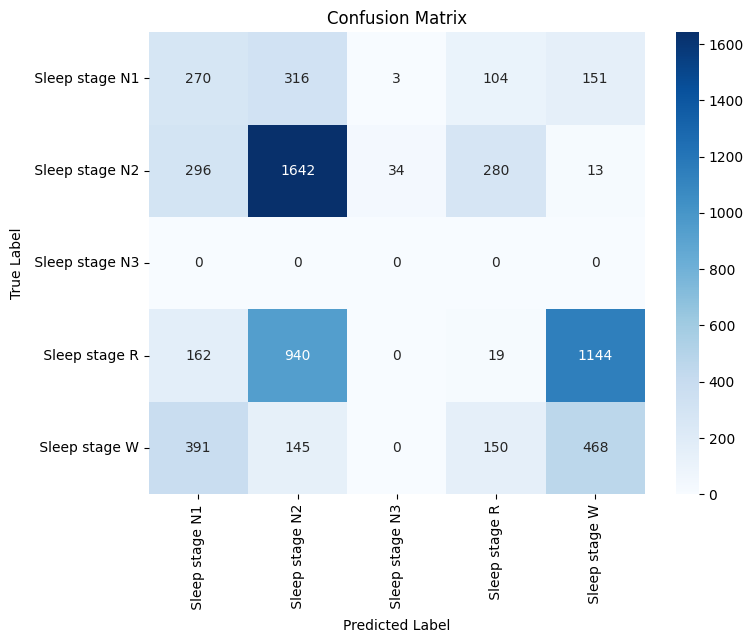

                 precision    recall  f1-score   support

 Sleep stage N1       0.24      0.32      0.28       844
 Sleep stage N2       0.54      0.72      0.62      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.03      0.01      0.01      2265
  Sleep stage W       0.26      0.41      0.32      1154

       accuracy                           0.37      6528
      macro avg       0.22      0.29      0.25      6528
   weighted avg       0.28      0.37      0.31      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [63]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))